# Latent Case Study

We aim to investigate, in depth, a specific component identified as a latent component for a known task (IOI).

In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name

from attribution_methods import integrated_gradients, activation_patching, highlight_components, asymmetry_score
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Identify latent components in IOI task

In [17]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to "
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to "
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input, prepend_bos=False)
corrupted_tokens = model.to_tokens(corrupted_input, prepend_bos=False)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([0.5434], device='cuda:0')
Corrupted logit difference: tensor([0.5962], device='cuda:0')


In [25]:
mlp_corrupt_clean, attn_corrupt_clean = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)
mlp_clean_corrupt, attn_clean_corrupt = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-2.2724e-06], device='cuda:0')

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-2.5332e-06], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-5.1409e-07], device='cuda:0')

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-8.1956e-07], device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([-1.3262e-06], device='cuda:0')

Error (delta) for blocks.2.mlp.hook_post attribution: tensor([1.4752e-06], device='cuda:0')

Error (delta) for blocks.3.attn.hook_result attribution: tensor([-5.4389e-07], device='cuda:0')

Error (delta) for blocks.3.mlp.hook_post attribution: tensor([4.3735e-06], device='cuda:0')

Error (delta) for blocks.4.attn.hook_result attribution: tensor([-1.0976e-06], device='cuda:0')

Error (delta) for blocks.4.mlp.hook_post attribution: tensor([-4.3437e-06], device='cuda:0')

Error (delta) for blocks.5.attn.hook_result at

In [26]:
ig_mlp_asymmetry = asymmetry_score(mlp_corrupt_clean, mlp_clean_corrupt, is_ig=True)
ig_attn_asymmetry = asymmetry_score(attn_corrupt_clean, attn_clean_corrupt, is_ig=True)

latent_attn, latent_attn_indices = highlight_components(ig_attn_asymmetry)
latent_mlp, latent_mlp_indices = highlight_components(ig_mlp_asymmetry)

In [30]:
torch.save(latent_attn, "results/case_study/latent_attn.pt")
torch.save(latent_mlp, "results/case_study/latent_mlp.pt")

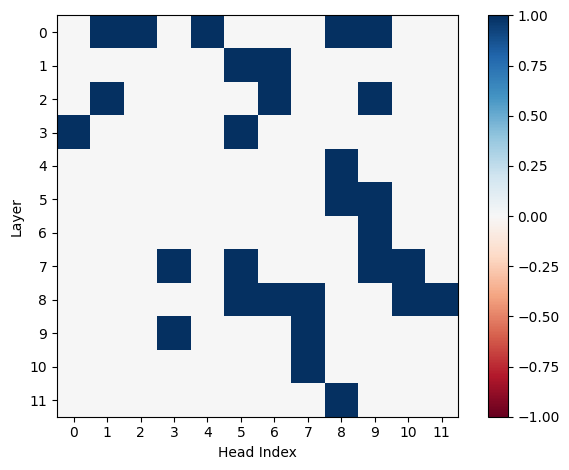

In [28]:
plot_attn(latent_attn[0].int(), model)

## Attributions under knock out

After ablating the most significant components identified in the IOI circuit, we examine the attribution scores of the remaining components, particularly the latent components.

## Pairwise ablation

We pick the latent component (X, Y), and ablate it alongside every significant component and latent component. For each ablated pair, we measure the logit difference to quantify the total effect on the model's output.